# CS 672 (CRN: 74071): Introduction to Deep Learning
## Christina Hyman

I applied transfer learning using the pre-trained InceptionV3 model in TensorFlow for binary classification on a dataset of 25,000 cat and dog images. 

The InceptionV3 model achieved a validation accuracy of 99.08% after nine epochs, significantly outperforming the base Sequential model built with TensorFlow.Keras, which reached 76.18% validation accuracy after the same number of epochs.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pathlib
import zipfile
import random
import tensorflow as tf
import json
from sklearn.metrics import accuracy_score
from shutil import copyfile
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from google.colab import files, drive

In [2]:
!wget --no-check-certificate \
    "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip" \
    -O "/tmp/cats-and-dogs.zip"

local_zip = '/tmp/cats-and-dogs.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

--2024-11-09 01:41:59--  https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip
Resolving download.microsoft.com (download.microsoft.com)... 23.192.208.155, 2600:1409:9800:480::317f, 2600:1409:9800:48e::317f
Connecting to download.microsoft.com (download.microsoft.com)|23.192.208.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 824887076 (787M) [application/octet-stream]
Saving to: ‘/tmp/cats-and-dogs.zip’

/tmp/cats-and-dogs. 100%[===================>] 786.67M  81.5MB/s    in 10s     

2024-11-09 01:42:09 (78.9 MB/s) - ‘/tmp/cats-and-dogs.zip’ saved [824887076/824887076]



The code downloads a zip file containing a dataset of cats and dogs images from a Microsoft server. It then extracts the contents of this zip file into the `/tmp` directory of Google Colab.

In [3]:
def is_image_corrupted(file_path):
    try:
        # Attempt to open the image
        with Image.open(file_path) as img:
            img.verify()
        return False  # Image is not corrupted
    except Exception as e:
        print(f"Corrupted image: {file_path} - {str(e)}")
        return True  # Image is corrupted

def remove_corrupted_images(folder_path):
    for root, dirs, files in os.walk(folder_path):
        for file_name in files:
            file_path = os.path.join(root, file_name)
            if is_image_corrupted(file_path):
                os.remove(file_path)

dataset_folder = '/tmp/PetImages'

# Remove corrupted images from the dataset folder
remove_corrupted_images(dataset_folder)


Corrupted image: /tmp/PetImages/Dog/Thumbs.db - cannot identify image file '/tmp/PetImages/Dog/Thumbs.db'
Corrupted image: /tmp/PetImages/Dog/11702.jpg - cannot identify image file '/tmp/PetImages/Dog/11702.jpg'


/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


Corrupted image: /tmp/PetImages/Cat/Thumbs.db - cannot identify image file '/tmp/PetImages/Cat/Thumbs.db'
Corrupted image: /tmp/PetImages/Cat/666.jpg - cannot identify image file '/tmp/PetImages/Cat/666.jpg'


This step helps identify and remove corrupted or unreadable images.

The `is_image_corrupted` function uses the PIL library to attempt opening and verifying each image file. If an exception occurs, the image is flagged as corrupted.

The `remove_corrupted_images` function then removes these corrupted images from the dataset.

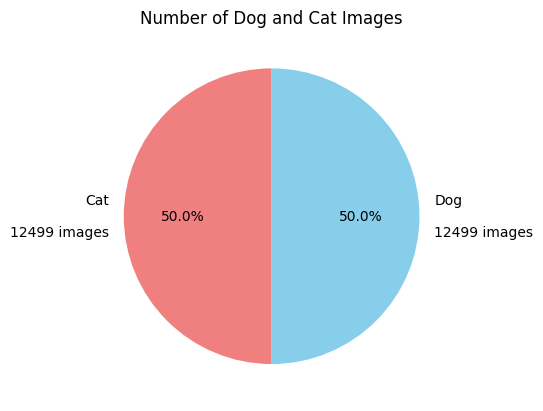

In [4]:
len_dog = len(os.listdir('/tmp/PetImages/Cat/'))
len_cat = len(os.listdir('/tmp/PetImages/Dog/'))

plt.pie(x=[len_cat, len_dog], labels=[f"Cat\n\n{len_cat} images", f"Dog\n\n{len_dog} images"], autopct='%1.1f%%', startangle=90, colors=['lightcoral', 'skyblue'])
plt.title("Number of Dog and Cat Images")
plt.show()

There are 12499 images in each directory for cats and dogs. There are an equal amount of images in the Dog and Cat class in this dataset.

In [5]:
try:
    os.mkdir('/tmp/cats-v-dogs')
    os.mkdir('/tmp/cats-v-dogs/train')
    os.mkdir('/tmp/cats-v-dogs/validation')
    os.mkdir('/tmp/cats-v-dogs/train/cats')
    os.mkdir('/tmp/cats-v-dogs/train/dogs')
    os.mkdir('/tmp/cats-v-dogs/validation/cats')
    os.mkdir('/tmp/cats-v-dogs/validation/dogs')
except OSError:
    pass

Directories are made to split the Cat vs. Dog dataset into train and validation folders. 

The final four directories place "cat" and "dog" subfolders within both the train and validation folders.

In [6]:
def split_data(SOURCE, TRAIN, VALIDATION, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = SOURCE + filename
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(filename + " is zero length, so ignoring.")

    train_length = int(len(files) * SPLIT_SIZE)
    validation_length = int(len(files) - train_length)
    shuffled_set = random.sample(files, len(files))
    train_set = shuffled_set[0:train_length]
    validation_set = shuffled_set[-validation_length:]

    for filename in train_set:
        this_file = SOURCE + filename
        destination = TRAIN + filename
        copyfile(this_file, destination)

    for filename in validation_set:
        this_file = SOURCE + filename
        destination = VALIDATION + filename
        copyfile(this_file, destination)


CAT_SOURCE_DIR = "/tmp/PetImages/Cat/"
TRAIN_CATS_DIR = "/tmp/cats-v-dogs/train/cats/"
VALIDATION_CATS_DIR = "/tmp/cats-v-dogs/validation/cats/"
DOG_SOURCE_DIR = "/tmp/PetImages/Dog/"
TRAIN_DOGS_DIR = "/tmp/cats-v-dogs/train/dogs/"
VALIDATION_DOGS_DIR = "/tmp/cats-v-dogs/validation/dogs/"

split_size = .8
split_data(CAT_SOURCE_DIR, TRAIN_CATS_DIR, VALIDATION_CATS_DIR, split_size)
split_data(DOG_SOURCE_DIR, TRAIN_DOGS_DIR, VALIDATION_DOGS_DIR, split_size)

Each directory is represented by a variable for easier reference. 

The `split_data` function is used to divide the data from the source directory into training and validation sets, following an 80-20 split ratio. This function is then applied to organize cat and dog images into separate training and validation sets.

In [7]:
len_train_cats, len_train_dogs = len(os.listdir('/tmp/cats-v-dogs/train/cats/')), len(os.listdir('/tmp/cats-v-dogs/train/dogs/'))
len_validation_cats, len_validation_dogs = len(os.listdir('/tmp/cats-v-dogs/validation/cats/')), len(os.listdir('/tmp/cats-v-dogs/validation/dogs/'))

print(f"There are {len_train_cats} images of cats and {len_train_dogs} images of dogs in the train dataset.")
print(f"There are {len_validation_cats} images of cats and {len_validation_dogs} images of dogs in the validation dataset.")

There are 9999 images of cats and 9999 images of dogs in the train dataset.
There are 2500 images of cats and 2500 images of dogs in the validation dataset.


In [8]:
def average_image_shape(directory):
    total_width, total_height, total_images = 0, 0, 0

    # Iterate through all images in the directory
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)

        # Open the image using PIL
        with Image.open(file_path) as img:
            width, height = img.size

        total_width += width
        total_height += height
        total_images += 1

    # Calculate the average width and height
    average_width, average_height = total_width // total_images, total_height // total_images

    return average_width, average_height

# Calculate the average shape for cats and dogs images
average_cat_shape, average_dog_shape = average_image_shape(CAT_SOURCE_DIR), average_image_shape(DOG_SOURCE_DIR)

print("Average shape of cat images:", average_cat_shape)
print("Average shape of dog images:", average_dog_shape)

Average shape of cat images: (410, 356)
Average shape of dog images: (398, 365)


The `average_image_shape` function calculates the average shape of all images for each class. This helps provide an understanding of the average number of pixels in each image.

In [9]:
# Create ImageDataGenerators for train and validation data
TRAIN_DIR = "/tmp/cats-v-dogs/train/"
train_datagen = ImageDataGenerator(
    rescale=1./255,                # Rescale pixel values to [0, 1]
    rotation_range=40,             # Randomly rotate images by up to 40 degrees
    width_shift_range=0.2,         # Shift images horizontally by up to 20%
    height_shift_range=0.2,        # Shift images vertically by up to 20%
    shear_range=0.2,               # Shear images by up to 20%
    zoom_range=0.2,                # Zoom into images by up to 20%
    horizontal_flip=True,          # Randomly flip images horizontally
    fill_mode='nearest'            # Fill pixels with nearest pixel values
)

# Flow train images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

# Flow validation images in batches of 32 using validation_datagen generator
VALIDATION_DIR = "/tmp/cats-v-dogs/validation/"
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

Found 19998 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


These generators load and preprocess images in batches from the specified directories for both training and validation. In `train_datagen`, data augmentation is applied by rescaling the images and performing random rotations, shifts, shears, zooms, and flips to enhance generalization during training. For validation, a `validation_datagen` generator only rescales the images.

Both the `train_generator` and `validation_generator` resizes the images to 224 x 224 pixels and loads and processes the images in batches of 32.

In [10]:
# Find the shape of the train samples
train_sample_shape = train_generator.image_shape
print("Shape of Train Samples:", train_sample_shape)

# Find the shape of the validation samples
validation_sample_shape = validation_generator.image_shape
print("Shape of Validation Samples:", validation_sample_shape)


Shape of Train Samples: (224, 224, 3)
Shape of Validation Samples: (224, 224, 3)


### Viewing and Reshaping Images

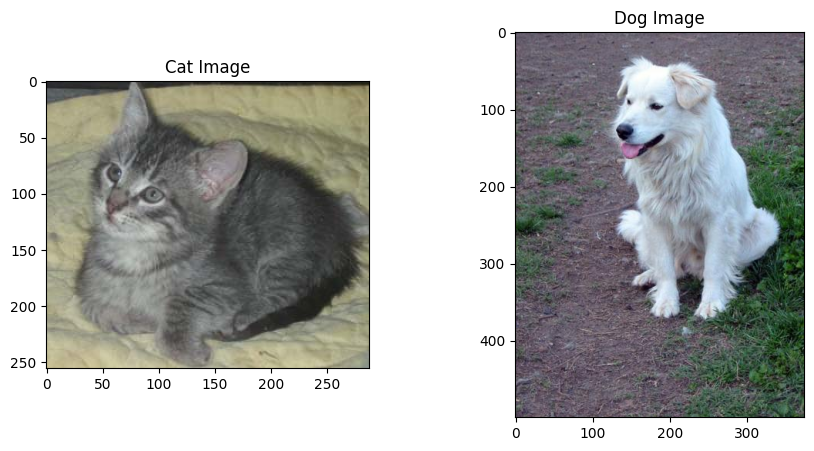

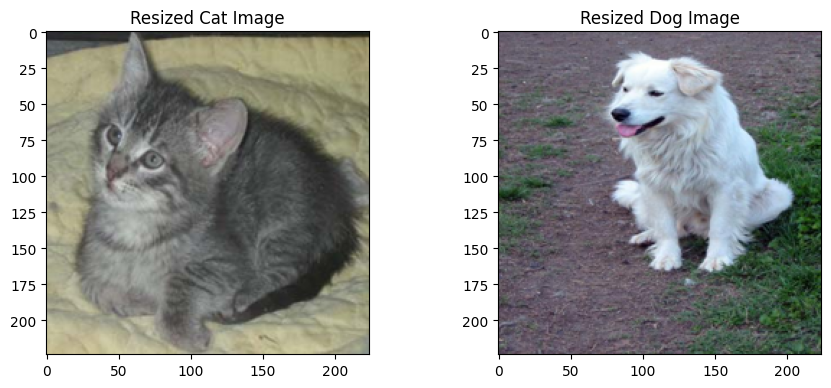

In [13]:
# Path to sample cat images in the original dimensions
sample_cat_path = "/tmp/cats-v-dogs/validation/cats/698.jpg"
sample_dog_path = "/tmp/cats-v-dogs/validation/dogs/988.jpg"

# Load the images
sample_cat = load_img(sample_cat_path)
sample_dog = load_img(sample_dog_path)

# Display the original images with some space in between
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)  # Adjust the horizontal space

axes[0].imshow(sample_cat)
axes[0].set_title('Cat Image')

axes[1].imshow(sample_dog)
axes[1].set_title('Dog Image')

plt.show()

# Resize the images to the target size
target_size = (224, 224)
resized_sample_cat = Image.fromarray(img_to_array(sample_cat).astype('uint8')).resize(target_size)
resized_sample_dog = Image.fromarray(img_to_array(sample_dog).astype('uint8')).resize(target_size)

# Convert the resized images back to NumPy arrays for display
resized_sample_cat_array = img_to_array(resized_sample_cat)
resized_sample_dog_array = img_to_array(resized_sample_dog)

# Display the resized images with some space in between
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
fig.subplots_adjust(wspace=0.4)  # Adjust the horizontal space

axes[0].imshow(resized_sample_cat_array.astype('uint8'))
axes[0].set_title('Resized Cat Image')

axes[1].imshow(resized_sample_dog_array.astype('uint8'))
axes[1].set_title('Resized Dog Image')

plt.show()


TensorFlow libraries are used to display side-by-side comparisons of original cat and dog images with their resized versions, providing a visual insight into the transformation process.

## Model Implementation & Evaluation

### TensorFlow.Keras Base Model

#### Defining, Training, and Evaluating TensorFlow.Keras Base Model

**Input Dimensions**: The Convolutional Neural Network (CNN) is designed for input images of shape (224, 224, 3), representing RGB images with a resolution of 224x224 pixels.

**Model Architecture and Compilation**: The model incorporates two convolutional layers, each followed by pooling layers to extract hierarchical features. The output is then flattened from a multi-dimensional array to a one-dimensional array. Dense layers are added, with the final output layer using a sigmoid activation function to provide a probability score indicating the likelihood of the image being classified as either a cat or a dog.

In [14]:
# Create a Sequential model
model_tensorflow = models.Sequential()

# Add Convolutional layers
model_tensorflow.add(Input(shape=(224, 224, 3)))
model_tensorflow.add(layers.Conv2D(16, (3, 3), activation='relu'))
model_tensorflow.add(layers.MaxPooling2D((2, 2)))
model_tensorflow.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_tensorflow.add(layers.MaxPooling2D((2, 2)))
model_tensorflow.add(layers.Flatten())
model_tensorflow.add(layers.Dense(64, activation='relu'))
model_tensorflow.add(layers.Dense(1, activation='sigmoid'))


# Compile the model
model_tensorflow.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model summary
model_tensorflow.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 93312)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       5,972,032 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,977,185 (22.80 MB)

 Trainable params: 5,977,185 (22.80 MB)

 Non-trainable params: 0 (0.00 B)

There are 5,977,185 parameters in the sequential model. All parameters in the model are trainable, and they will be updated during training.

In [15]:
# Train the model using the fit method
history = model_tensorflow.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


624/624 ━━━━━━━━━━━━━━━━━━━━ 257s 400ms/step - accuracy: 0.5854 - loss: 0.8144 - val_accuracy: 0.6865 - val_loss: 0.5802
Epoch 2/10
  1/624 ━━━━━━━━━━━━━━━━━━━━ 21s 34ms/step - accuracy: 0.5938 - loss: 0.6145

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.5938 - loss: 0.6145 - val_accuracy: 0.6250 - val_loss: 0.5798
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 251s 392ms/step - accuracy: 0.6725 - loss: 0.5992 - val_accuracy: 0.7482 - val_loss: 0.5095
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.7188 - loss: 0.5180 - val_accuracy: 0.7500 - val_loss: 0.3992
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 251s 399ms/step - accuracy: 0.7139 - loss: 0.5524 - val_accuracy: 0.7155 - val_loss: 0.5712
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 667us/step - accuracy: 0.6562 - loss: 0.6394 - val_accuracy: 1.0000 - val_loss: 0.2495
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 247s 389ms/step - accuracy: 0.7204 - loss: 0.5430 - val_accuracy: 0.7458 - val_loss: 0.5054
Epoch 8/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.6562 - loss: 0.7088 - val_accuracy: 1.0000 - val_loss: 0.1574
Epoch 9/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 260s 392ms/step - accuracy: 0.7304 - loss: 0.5354 - val_acc

After training the convolutional neural network for 10 epochs with the Adam optimizer (learning rate = 0.001) and binary cross-entropy loss, the model achieved a validation accuracy of 87.50%. The fluctuating training history across epochs indicates potential instability in the model's reliability.

Run time is 17 mins.

#### Saving Tensorflow Base Model Train History Results

In [16]:
# Save the training history (accuracy, loss, etc.) as a JSON file
history_dict = history.history
with open('training_history.json', 'w') as f:
    json.dump(history_dict, f)

# Download the file to local machine
files.download('training_history.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Plotting Tensorflow Base Model Loss and Accuracy Curves

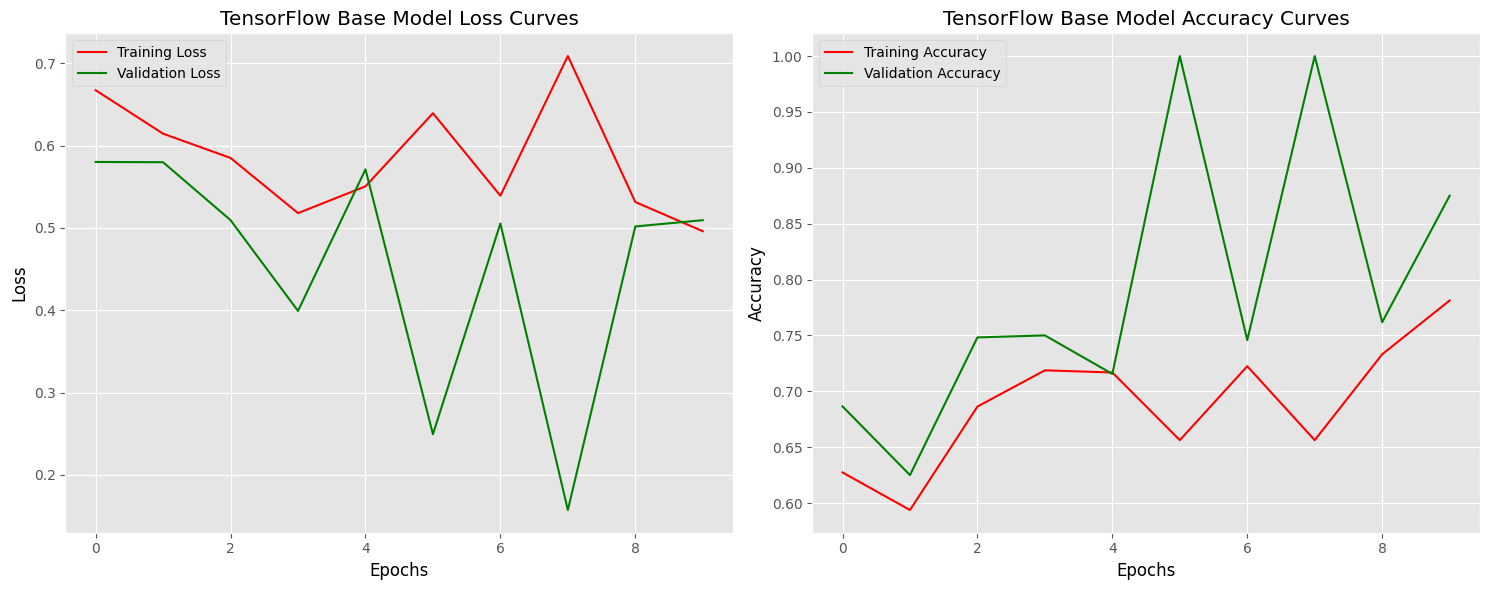

In [18]:
plt.style.use('ggplot')

# Extract loss and accuracy from the training history
loss_tensorflow = history.history['loss']
val_loss_tensorflow = history.history['val_loss']
accuracy_tensorflow = history.history['accuracy']
val_accuracy_tensorflow = history.history['val_accuracy']

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss curves
ax1.plot(loss_tensorflow, color='red', label='Training Loss')
ax1.plot(val_loss_tensorflow, color='green', label='Validation Loss')
ax1.set_title('TensorFlow Base Model Loss Curves')
ax1.set_xlabel('Epochs', color='black')
ax1.set_ylabel('Loss', color='black')
ax1.legend()

# Plot accuracy curves
ax2.plot(accuracy_tensorflow, color='red', label='Training Accuracy')
ax2.plot(val_accuracy_tensorflow, color='green', label='Validation Accuracy')
ax2.set_title('TensorFlow Base Model Accuracy Curves')
ax2.set_xlabel('Epochs', color='black')
ax2.set_ylabel('Accuracy', color='black')
ax2.legend()

plt.tight_layout()
plt.show()

### Transfer Learning using the InceptionV3 Model

#### Defining, Training, and Evaluation Pre-trained InceptionV3 Model

**InceptionV3 Model**: Utilizes the pre-trained InceptionV3 network, leveraging knowledge acquired from ImageNet to transfer to the current classification task.

**Freezing Layers**: The initial layers are frozen to retain learned transferable features from ImageNet, promoting more efficient training on the new data.

**Custom Task Layers**: Includes global average pooling and a dense layer for outputting the probability of an image being classified as a cat or dog.

**Model Compilation**: Compiled with the Adam optimizer, binary cross-entropy loss, and accuracy as the evaluation metric for training.

**Outcome**: Applying the pre-trained InceptionV3 model leads to more efficient training and higher accuracy for the task at hand.

In [19]:
# Pre-trained InceptionV3 Model
inception_model = InceptionV3(input_shape=(224, 224, 3), include_top=False, weights='imagenet')

# Freeze the layers of InceptionV3
for layer in inception_model.layers:
    layer.trainable = False

# Add a custom top to the InceptionV3 model
x = layers.GlobalAveragePooling2D()(inception_model.output)
x = layers.Dense(1, activation='sigmoid')(x)

# Define the final model
model_inception = models.Model(inputs=inception_model.input, outputs=x)

# Compile the model
model_inception.compile(optimizer=Adam(learning_rate=0.001),
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

# Display the model summary
model_inception.summary()

# Train the InceptionV3 model
history_inception = model_inception.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size
)


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 111, 111, 32)   │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_5[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 21,804,833 (83.18 MB)

 Trainable params: 2,049 (8.00 KB)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/10
541/624 ━━━━━━━━━━━━━━━━━━━━ 35s 424ms/step - accuracy: 0.9279 - loss: 0.1775

/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))


624/624 ━━━━━━━━━━━━━━━━━━━━ 295s 445ms/step - accuracy: 0.9323 - loss: 0.1677 - val_accuracy: 0.9890 - val_loss: 0.0364
Epoch 2/10
  1/624 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 1.0000 - loss: 0.0427

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


624/624 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 1.0000 - loss: 0.0427 - val_accuracy: 1.0000 - val_loss: 0.0144
Epoch 3/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 295s 427ms/step - accuracy: 0.9773 - loss: 0.0634 - val_accuracy: 0.9884 - val_loss: 0.0351
Epoch 4/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 10s 17ms/step - accuracy: 0.9688 - loss: 0.0476 - val_accuracy: 1.0000 - val_loss: 3.8548e-04
Epoch 5/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 313s 429ms/step - accuracy: 0.9729 - loss: 0.0664 - val_accuracy: 0.9884 - val_loss: 0.0353
Epoch 6/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.0623 - val_accuracy: 1.0000 - val_loss: 1.6876e-04
Epoch 7/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 268s 425ms/step - accuracy: 0.9752 - loss: 0.0650 - val_accuracy: 0.9914 - val_loss: 0.0316
Epoch 8/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 0s 77us/step - accuracy: 1.0000 - loss: 0.0171 - val_accuracy: 1.0000 - val_loss: 0.0138
Epoch 9/10
624/624 ━━━━━━━━━━━━━━━━━━━━ 268s 425ms/step - accuracy: 0.9766 - loss: 0.0585 -

There are a total of 21,804,833 parameters, but only 2049 parameters are being trained.

The validation accuracy after the ninth epoch is 99.08%, which is 30.06% higher compared to the validation accuracy of the Tensorflow.Keras Convolutional Neural Network Model after the ninth epoch.

Run time is 25 min 14 seconds.

#### Saving InceptionV3 Model Train History Results

In [20]:
# Save the Inception model training history (accuracy, loss, etc.) as a JSON file
history_inception_dict = history_inception.history
with open('inception_training_history.json', 'w') as f:
    json.dump(history_inception_dict, f)

# Download the file to local machine
files.download('inception_training_history.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#### Plotting InceptionV3 Model Loss and Accuracy Curves

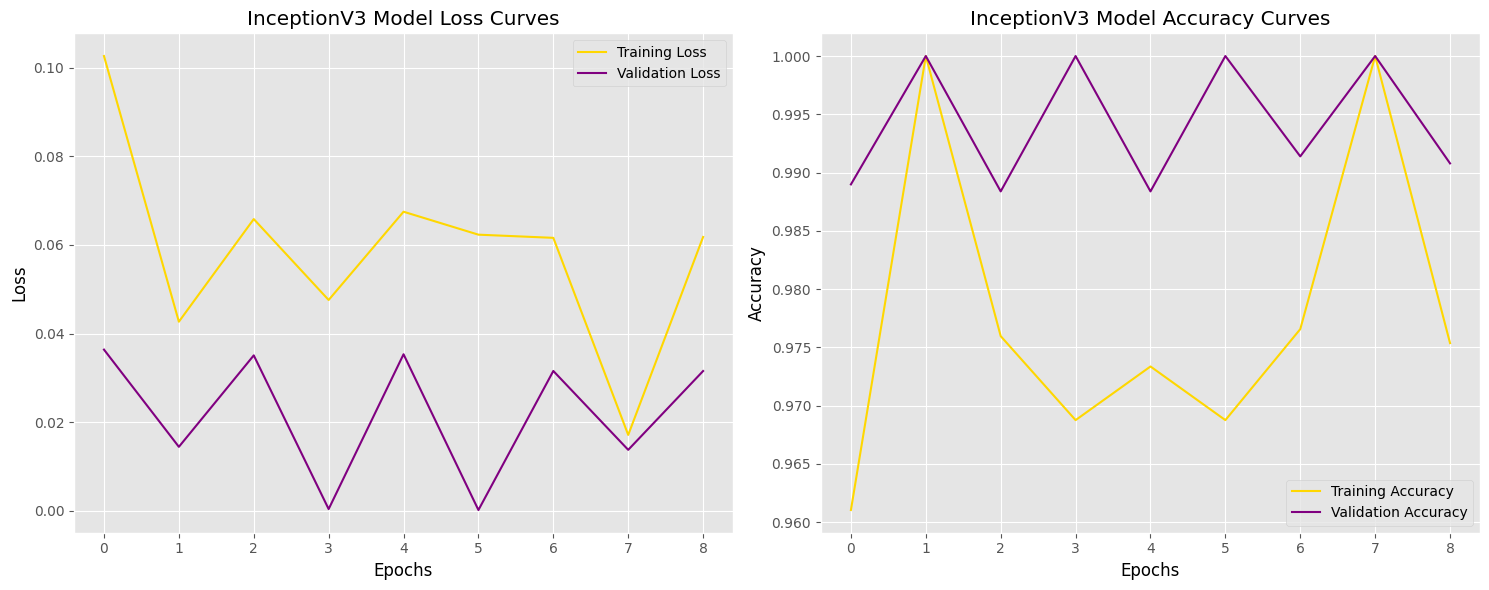

In [21]:
plt.style.use('ggplot')

# Extract loss and accuracy from the training history for the transfer learning model
loss_inception = history_inception.history['loss']
val_loss_inception = history_inception.history['val_loss']
accuracy_inception = history_inception.history['accuracy']
val_accuracy_inception = history_inception.history['val_accuracy']

# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss curves
ax1.plot(loss_inception, color='gold', label='Training Loss')
ax1.plot(val_loss_inception, color='purple', label='Validation Loss')
ax1.set_title('InceptionV3 Model Loss Curves')
ax1.set_xlabel('Epochs', color='black')
ax1.set_ylabel('Loss', color='black')
ax1.legend()

# Plot accuracy curves
ax2.plot(accuracy_inception, color='gold', label='Training Accuracy')
ax2.plot(val_accuracy_inception, color='purple', label='Validation Accuracy')
ax2.set_title('InceptionV3 Model Accuracy Curves')
ax2.set_xlabel('Epochs', color='black')
ax2.set_ylabel('Accuracy', color='black')
ax2.legend()

plt.tight_layout()
plt.show()

### Plotting Sequential Tensorflow.Keras Model and InceptionV3 Model Loss and Accuracy Curves

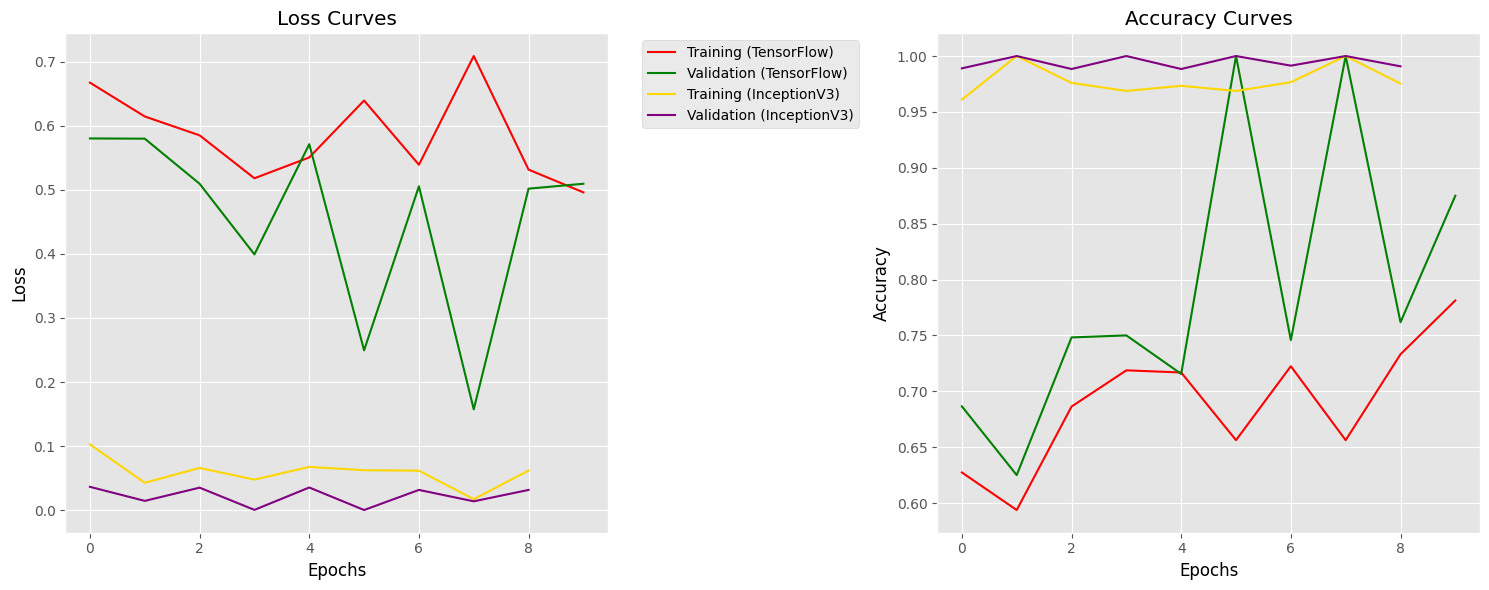

In [34]:
# Create subplots for loss and accuracy
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot loss curves for home-grown model and transfer learning model
ax1.plot(loss_tensorflow, color='red', label='Training (TensorFlow)')
ax1.plot(val_loss_tensorflow, color='green', label='Validation (TensorFlow)')
ax1.plot(loss_inception, color='gold', label='Training (InceptionV3)')
ax1.plot(val_loss_inception, color='purple', label='Validation (InceptionV3)')
ax1.set_title('Loss Curves')
ax1.set_xlabel('Epochs', color='black')
ax1.set_ylabel('Loss', color='black')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Plot accuracy curves for home-grown model and transfer learning model
ax2.plot(accuracy_tensorflow, color='red')
ax2.plot(val_accuracy_tensorflow, color='green')
ax2.plot(accuracy_inception, color='gold')
ax2.plot(val_accuracy_inception, color='purple')
ax2.set_title('Accuracy Curves')
ax2.set_xlabel('Epochs', color='black')
ax2.set_ylabel('Accuracy', color='black')

plt.tight_layout()
plt.show()

## Conclusion:
* **TensorFlow.Keras Base Model**: Shows signs of overfitting and instability in validation accuracy. This indicates the model may not generalize well to new data and might benefit from further tuning (e.g., regularization, data augmentation, or early stopping).
* **InceptionV3 Model**: Demonstrates strong performance on both training and validation datasets, indicating that the model is well-trained and generalizes well.

For the TensorFlow.Keras Base Model, I can consider:
* Using more regularization techniques (e.g., dropout layers or L2 regularization).
* Increasing data augmentation to make the model more robust.
* Reducing the model's complexity if overfitting persists.<br>

For the InceptionV3 Model, the current results suggest that the model is already well-optimized.
Overall, InceptionV3 seems to be the better-performing model for this task based on the graphs provided.